In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np

In [2]:
import os
import math
import pandas as pd
from sympy import isprime
from multiprocessing import Pool

In [3]:
df_cities = pd.read_csv(r'C:\Users\Admin\Desktop\routing problem/cities.csv')
df_cities.head()

,CityId,X,Y
0,0,316.836739,2202.340707
1,1,4377.405972,336.602082
2,2,3454.158198,2820.053011
3,3,4688.099298,2935.898056
4,4,1010.696952,3236.750989


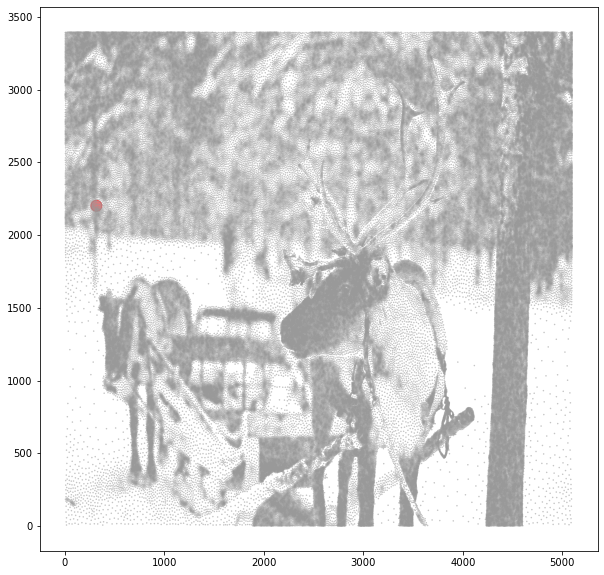

In [4]:
fig = plt.figure(figsize=(10,10))
#cmap, norm = from_levels_and_colors([0.0, 0.5, 1.5], ['red', 'black'])
plt.scatter(df_cities['X'],df_cities['Y'],marker = '.',
            c=(df_cities.CityId != 0).astype(int), cmap='Set1', 
            alpha = 0.6, s = 500*(df_cities.CityId == 0).astype(int)+1)
plt.show()

In [5]:
# The function to get the distance between the cities.
def distance(x1, y1, x2, y2, prev_is_prime, is_10th):
    # Every 10th step is 10% more lengthy unless coming from a prime CityId.
    cost_factor = 1.1 if is_10th and not prev_is_prime else 1.0
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2) * cost_factor

# The function to calculate score.

def calculate_score(path, cities_df_dict):
    # The beginning and end of the paths must be City'0'.
    paths = [0]
    paths.extend(path)
    paths.extend([0])
    sum_distance = 0
    prev_x, prev_y = cities_df_dict['X'][0], cities_df_dict['Y'][0]
    prev_is_prime = False

    for i, city in enumerate(paths):
        x, y = cities_df_dict['X'][city], cities_df_dict['Y'][city]
        is_prime = cities_df_dict['IsPrime'][city]

        sum_distance += distance(prev_x, prev_y, x, y, prev_is_prime, i % 10 == 0)
        prev_x, prev_y = x, y
        prev_is_prime = is_prime

    return sum_distance

In [6]:
df_cities['IsPrime'] = df_cities.CityId.apply(isprime)
cities_df_dict       = df_cities.to_dict()

df_cities.head(5)

,CityId,X,Y,IsPrime
0,0,316.836739,2202.340707,False
1,1,4377.405972,336.602082,False
2,2,3454.158198,2820.053011,True
3,3,4688.099298,2935.898056,True
4,4,1010.696952,3236.750989,False


In [7]:
# start and end in the nort (0)
path  = df_cities.CityId[:].values[1:]
score = calculate_score(path, cities_df_dict)
print('Total distance with the dumbest path is '+ "{:,}".format(score))

Total distance with the dumbest path is 446,884,407.5212135


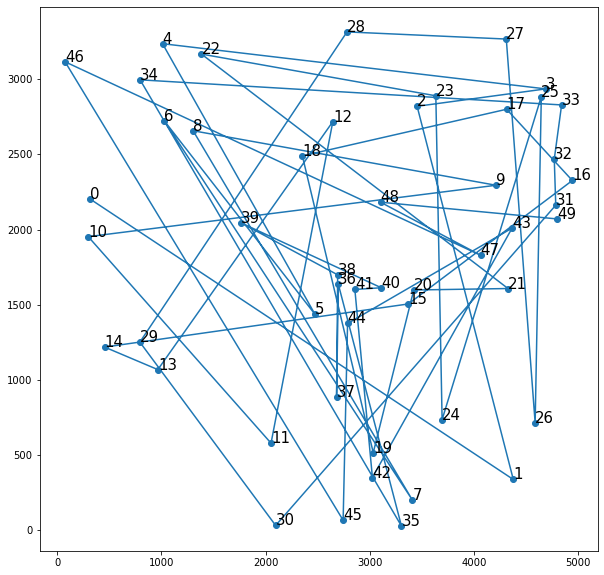

In [8]:
dumbest_path = path

def plot_sample_path(path):
    df_path = pd.merge_ordered(pd.DataFrame({'CityId':path}),df_cities,on=['CityId'])
    fig, ax = plt.subplots(figsize=(10,10))
    ax.plot(df_path.iloc[0:50,]['X'], df_path.iloc[0:50,]['Y'],marker = 'o')
    for i, txt in enumerate(df_path.iloc[0:50,]['CityId']):
        ax.annotate(txt, (df_path.iloc[0:50,]['X'][i], df_path.iloc[0:50,]['Y'][i]),size = 15)
        
plot_sample_path(dumbest_path)

In [9]:
df_cities.head(10)

,CityId,X,Y,IsPrime
0,0,316.836739,2202.340707,False
1,1,4377.405972,336.602082,False
2,2,3454.158198,2820.053011,True
3,3,4688.099298,2935.898056,True
4,4,1010.696952,3236.750989,False
5,5,2474.230877,1435.514651,True
6,6,1029.277795,2721.800952,False
7,7,3408.887685,199.585793,True
8,8,1304.006125,2657.427246,False
9,9,4211.525725,2294.595208,False


In [10]:
print("All cities: ", df_cities.shape)
print("Prime cities: ", df_cities[df_cities.IsPrime].shape)

All cities:  (197769, 4)
Prime cities:  (17802, 4)


In [11]:
class GeneticAlgorithm(object):
    def __init__(self, genetics):
        self.genetics       = genetics
        self.best_solution  = None
        self.avg_fitness    = []
        pass

    def fitness(self, ch):
        return (self.genetics.fitness(ch),  ch)
    
    def run(self, processes=4):
        population = self.genetics.initial()
        pool       = Pool(processes=processes)
        
        while True:
            fits_pops = [self.fitness(ch) for ch in population]
            fits_pops = list(sorted(fits_pops))
            self.avg_fitness.append(np.mean([f for f, ch in fits_pops]))
            self.best_solution = fits_pops[0][1]
            
            if self.genetics.check_stop(fits_pops): 
                break
            
            population = self.next(fits_pops)
            pass
        return population

    def next(self, fits):
        parents_generator = self.genetics.parents(fits)
        size  = len(fits)
        nexts = [self.best_solution.copy()]
        while len(nexts) < size:
            parents  = next(parents_generator)
            cross    = random.random() < self.genetics.probability_crossover()
            children = self.genetics.crossover(parents) if cross else parents

            for ch in children:
                mutate = random.random() < self.genetics.probability_mutation()
                nexts.append(self.genetics.mutation(ch) if mutate else ch)
                pass
            pass
        return nexts[0:size]
    pass

In [12]:
class TravelingSanta():
    def __init__(self, df_cities, generation=10, size=5,
                 prob_crossover=0.9, 
                 prob_mutation=0.2):
        self.df_cities  = df_cities
        
        self.counter   = 0
        
        self.generation = generation
        self.size  = size        
        self.prob_crossover = prob_crossover
        self.prob_mutation  = prob_mutation
        self.cities_df_dict = df_cities.to_dict()

    # GeneticFunctions interface impls
    def probability_crossover(self):
        return self.prob_crossover
    def probability_mutation(self):
        return self.prob_mutation

    # Initial population based in s0
    def initial(self):
        population = [self.random_chromo() for j in range(self.size)]
        return population

    def fitness(self, chromo):
        score = calculate_score(chromo, self.cities_df_dict)
        return score

    def check_stop(self, fits_populations):
        self.counter += 1
        
        if self.counter % 2 == 0:

            fits  = [f for f, ch in fits_populations]
            best  = min(fits)
            worst = max(fits)
            ave   = sum(fits) / len(fits)
            print(
                "[G %3d] score=(%2f, %2f, %2f, %2f): %r" %
                (self.counter, best, ave, worst, len(fits), []))
            pass

        return self.counter >= self.generation

    def parents(self, fits_populations):
        while True:
            father = self.tournament(fits_populations)
            mother = self.tournament(fits_populations)
            yield (father, mother)
            pass
        pass

    def crossover(self, parents):
        ind1, ind2 = parents
        
        size = min(len(ind1), len(ind2))
        a, b = random.sample(range(size), 2)
        if a > b:
            a, b = b, a

        holes1, holes2 = [True]*size, [True]*size
        for i in range(size):
            if i < a or i > b:
                holes1[ind2[i]-1] = False
                holes2[ind1[i]-1] = False

        # We must keep the original values somewhere before scrambling everything
        temp1, temp2 = ind1, ind2
        k1 , k2 = b + 1, b + 1
        for i in range(size):
            if not holes1[temp1[(i + b + 1) % size]-1]:
                ind1[k1 % size] = temp1[(i + b + 1) % size]
                k1 += 1

            if not holes2[temp2[(i + b + 1) % size]-1]:
                ind2[k2 % size] = temp2[(i + b + 1) % size]
                k2 += 1

        # Swap the content between a and b (included)
        for i in range(a, b + 1):
            ind1[i], ind2[i] = ind2[i], ind1[i]

        return ind1, ind2

    def mutation(self, chromosome):
        mutated = chromosome
        
        for i in range(int(len(chromosome)*0.05)):
            i1 = random.randint(0, len(chromosome)-1)
            i2 = random.randint(0, len(chromosome)-1)
        
            origin       = mutated[i1]
            mutated[i1]  = mutated[i2]
            mutated[i2]  = origin

        return mutated
    def tournament(self, fits_populations):
        alicef, alice = self.select_random(fits_populations)
        bobf, bob = self.select_random(fits_populations)
        return alice if alicef < bobf else bob

    def select_random(self, fits_populations):
        return fits_populations[random.randint(0, len(fits_populations)-1)]

    def random_chromo(self):
        chromo = list(df_cities.CityId.sample(frac=1).values)
        return chromo
    pass

In [13]:
%%time

generation      = 10
population_size = 10
prob_crossover  = 0.9
prob_mutation   = 0.2

ga = GeneticAlgorithm(TravelingSanta(df_cities, generation=generation, size=population_size, 
                   prob_crossover=prob_crossover, prob_mutation=prob_mutation)
)

best_solution = ga.run()

[G   2] score=(446147937.376090, 446738093.983934, 447395686.976886, 10.000000): []
[G   4] score=(446147937.376090, 446442729.403124, 446663637.936427, 10.000000): []
[G   6] score=(446147937.376090, 446585855.394525, 446859546.178353, 10.000000): []
[G   8] score=(446147937.376090, 446345407.121494, 446544900.134196, 10.000000): []
[G  10] score=(446147937.376090, 446540819.038318, 446623693.026364, 10.000000): []
Wall time: 1min 36s


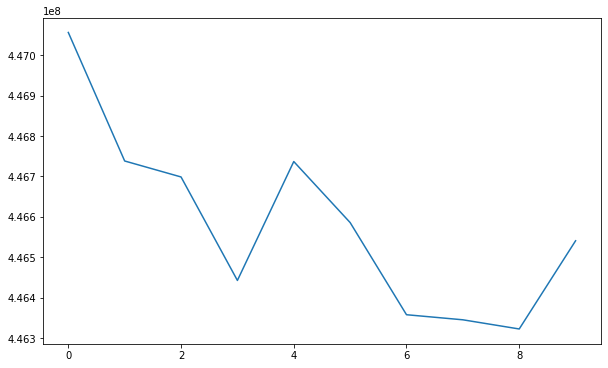

In [14]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(ga.avg_fitness)

In [15]:
calculate_score(ga.best_solution, cities_df_dict)

446147937.3760896

In [36]:
class FireflyAlgorithm:
    def __init__(self, pop_size=20, alpha=1.0, betamin=1.0, gamma=0.01, seed=None):
        self.pop_size = pop_size
        self.alpha = alpha
        self.betamin = betamin
        self.gamma = gamma
        self.rng = default_rng(seed)

    def run(self, function, dim, lb, ub, max_evals):
        fireflies = self.rng.uniform(lb, ub, (self.pop_size, dim))
        intensity = np.apply_along_axis(function, 1, fireflies)
        best = np.min(intensity)

        evaluations = self.pop_size
        new_alpha = self.alpha
        search_range = ub - lb

        while evaluations <= max_evals:
            new_alpha *= 0.97
            for i in range(self.pop_size):
                for j in range(self.pop_size):
                    if intensity[i] >= intensity[j]:
                        r = np.sum(np.square(fireflies[i] - fireflies[j]), axis=-1)
                        beta = self.betamin * np.exp(-self.gamma * r)
                        steps = new_alpha * (self.rng.random(dim) - 0.5) * search_range
                        fireflies[i] += beta * (fireflies[j] - fireflies[i]) + steps
                        fireflies[i] = np.clip(fireflies[i], lb, ub)
                        intensity[i] = function(fireflies[i])
                        evaluations += 1
                        best = min(intensity[i], best)
        return best